In [1]:
%matplotlib inline

In [2]:
from datetime import datetime
import gc
from IPython.display import Markdown
from os.path import join
from os.path import exists
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('big-darkgrid')

In [3]:
%%time
# This was created in 01_Initial_Ratings_EDA.ipynb
ratings_feather = '../preprocessed/ratings.feather'
# These were/will be created here
ratings_through_2013_feather = '../preprocessed/ratings-through-2013.feather'
ratings_2014_through_2015_feather = '../preprocessed/ratings-2014-through-2015.feather'

if exists(ratings_through_2013_feather) and exists(ratings_2014_through_2015_feather):
    print("Loading {}".format(ratings_through_2013_feather))
    ratings_df = pd.read_feather(ratings_through_2013_feather)
else:
    ratings_df_full = pd.read_feather(ratings_feather)
    ratings_df = ratings_df_full[ratings_df_full['year'] <= 2013].copy()
    print("Writing {}".format(ratings_through_2013_feather))
    ratings_df.to_feather(ratings_through_2013_feather)
    print("Writing {}".format(ratings_2014_through_2015_feather))
    (ratings_df_full[ratings_df_full['year']>=2014]
     .reset_index(drop=True)
     .to_feather(ratings_2014_through_2015_feather)
    )
    del ratings_df_full
    gc.collect()
display(ratings_df.tail())

Loading ../preprocessed/ratings-through-2013.feather


,userId,movieId,rating,timestamp,year,month,day,hour,minute
19153905,120609,81562,3.0,2013-12-31 23:57:27,2013,12,31,23,57
19153906,120609,356,2.5,2013-12-31 23:57:36,2013,12,31,23,57
19153907,120609,74458,4.0,2013-12-31 23:57:47,2013,12,31,23,57
19153908,44501,70533,4.5,2013-12-31 23:58:07,2013,12,31,23,58
19153909,44501,96821,4.0,2013-12-31 23:58:34,2013,12,31,23,58


CPU times: user 885 ms, sys: 1.57 s, total: 2.45 s
Wall time: 17.9 s


In [62]:
class PerformanceOverTimeValidator():
    """Validator that evaluates model performance over time. For each time
    period tested, all data before that time period is used as training data.
    
    Parameters
    ----------
    model_ : object
        An object with public fit(X, y) and predict(X) methods.
    err_func_ : function, default=sklearn.metrics.mean_absolute_error
        A function used to evaluate performance for each time period.
        Arguments are y and y_pred, both of which are array-like with
        shape = [n_samples]
    n_year_period_ : int, default=1
        Number of years per test period
        
    Attributes
    ----------
    test_years_ : int list
        List of years, each of which marks the first year
        in a tested time period
    test_errs_ : float list, [n_periods_tested]
        List of test errors for each time period tested
    
    """
    def __init__(self, model, err_func=mean_absolute_error, n_year_period=1):
        self.model_ = model
        self.err_func_ = err_func
        self.n_year_period_ = n_year_period
        self.test_years_ = []
        self.test_errs_ = []
        
    def validate(self, X, y, years):
        """Computes test error using all previous data as training data
        over a set of years
        
        Paramters
        ---------
        X : {array-like}, shape = [n_samples, n_features]
            Feature vectors
        y : array-like, shape = [n_samples]
            Target variables
        years : array-like, shape = [n_samples]
        
        Returns
        -------
        test_years_ : int list, [n_periods_tested]
            List of years, each of which marks the first year
            in a tested time period
        test_errs_ : float list, [n_periods_tested]
            List of test errors for each time period tested
        """
        years = np.array(years)
        unique_years = np.unique(years)
        test_years = []
        test_errs = []
        for year in unique_years[self.n_year_period_::self.n_year_period_]:
            train_inds = years < year
            test_inds = (years >= year) & (years < year + self.n_year_period_)
            X_train, y_train = X[train_inds], y[train_inds]
            X_test, y_test = X[test_inds], y[test_inds]
            self.model_.fit(X_train, y_train)
            y_pred = self.model_.predict(X_test)
            err = self.err_func_(y_pred, y_test)
            test_years.append(year)
            test_errs.append(err)
        self.test_years_ = test_years
        self.test_errs_ = test_errs
        return test_years, test_errs

In [63]:
class SimpleAverageModel():
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.mean_ = y.mean()
    
    def predict(self, X):
        return np.ones(len(X)) * self.mean_

In [64]:
class AverageByIdModel():
    """Simple model that predicts based on average ratings for a given Id
    (movieId or userId) from training data
    
    Attributes
    ----------
    averages_by_id_ : pandas Series, shape = [n_ids]
        Pandas series of rating averages by id
    overall_average_ : float
        Average rating over all training samples
    """
    
    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ----------
        X : array-like, shape = [n_samples]
            Array of n_samples movieIds or userIds
        y : array-like, shape = [n_samples]
            Target values (movie ratings)
        
        Returns
        -------
        self : object
        """
        X_y_df = pd.DataFrame({'id': X, 'rating': y})
        self.averages_by_id_ = (
            X_y_df
            .groupby('id')['rating']
            .mean()
            .rename('average_rating')
        )
        self.overall_average_ = np.mean(y)
    
    def predict(self, X):
        """Return rating predictions
        
        Parameters
        ----------
        X : array-like, shape = [n_samples]
            Array of n_samples movieIds or userIds
        
        Returns
        -------
        y_pred : array-like, shape = [n_samples]
            Array of n_samples rating predictions
        """
        if isinstance(X, pd.DataFrame):
            if X.shape[1] > 1:
                raise ValueError(
                    "X should be a 1D array-like object"
                )
            X = X.iloc[:, 0]
        X_df = pd.DataFrame({'id': X})
        X_df = X_df.join(self.averages_by_id_, on='id')
        X_df['average_rating'].fillna(self.overall_average_, inplace=True)
        return X_df['average_rating'].values

In [65]:
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
    
    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    
    Attributes
    ----------
    mu_ : float
        Average rating over all training samples
    b_u_ : pandas Series, shape = [n_users]
        User residuals
    b_i_ : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor_ : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor_ = damping_factor
    
    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, 2]
            DataFrame with columns 'userId', and 'movieId'
        y : array-like, shape = [n_samples]
            Target values (movie ratings)
        
        Returns
        -------
        self : object
        """
        X = X.copy()
        X['rating'] = y
        self.mu_ = np.mean(y)
        user_counts = X['userId'].value_counts()
        movie_counts = X['movieId'].value_counts()
        b_u = (
            X[['userId', 'rating']]
            .groupby('userId')['rating']
            .sum()
            .subtract(user_counts * self.mu_)
            .divide(user_counts + self.damping_factor_)
            .rename('b_u')
        )
        X = X.join(b_u, on='userId')
        X['movie_residual'] = X['rating'] - X['b_u'] - self.mu_
        b_i = (
            X[['movieId', 'movie_residual']]
            .groupby('movieId')['movie_residual']
            .sum()
            .divide(movie_counts + self.damping_factor_)
            .rename('b_i')
        )
        self.b_u_ = b_u
        self.b_i_ = b_i
    
    def predict(self, X):
        """Return rating predictions
        
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, 2]
            DataFrame with columns 'userId', and 'movieId'
        
        Returns
        -------
        y_pred : array-like, shape = [n_samples]
            Array of n_samples rating predictions
        """
        X = X.copy()
        X = X.join(self.b_u_, on='userId').fillna(0)
        X = X.join(self.b_i_, on='movieId').fillna(0)
        return self.mu_ + X['b_u'] + X['b_i']

In [66]:
%%time
validator = PerformanceOverTimeValidator(SimpleAverageModel(), n_year_period=2)
years_1, errs_1 = validator.validate(ratings_df['userId'], ratings_df['rating'], years=ratings_df['year'])

CPU times: user 3.99 s, sys: 3.17 s, total: 7.15 s
Wall time: 7.41 s


In [72]:
%%time
validator = PerformanceOverTimeValidator(AverageByIdModel(), n_year_period=2)
years_2, errs_2 = validator.validate(ratings_df['userId'], ratings_df['rating'], ratings_df['year'])
years_3, errs_3 = validator.validate(ratings_df['movieId'], ratings_df['rating'], ratings_df['year'])

CPU times: user 18.9 s, sys: 10.6 s, total: 29.5 s
Wall time: 30.1 s


In [68]:
%%time
model = DampedUserMovieBaselineModel(damping_factor=0)
validator = PerformanceOverTimeValidator(model, n_year_period=2)
years_4, errs_4 = validator.validate(ratings_df[['userId', 'movieId']], ratings_df['rating'], ratings_df['year'])

CPU times: user 34.5 s, sys: 21.9 s, total: 56.3 s
Wall time: 1min 1s


In [69]:
%%time
model = DampedUserMovieBaselineModel(damping_factor=5)
validator = PerformanceOverTimeValidator(model, n_year_period=2)
years_5, errs_5 = validator.validate(ratings_df[['userId', 'movieId']], ratings_df['rating'], ratings_df['year'])

CPU times: user 34 s, sys: 22 s, total: 56.1 s
Wall time: 1min


In [70]:
%%time
model = DampedUserMovieBaselineModel(damping_factor=25)
validator = PerformanceOverTimeValidator(model, n_year_period=2)
years_6, errs_6 = validator.validate(ratings_df[['userId', 'movieId']], ratings_df['rating'], ratings_df['year'])

CPU times: user 33 s, sys: 20.6 s, total: 53.7 s
Wall time: 56.3 s


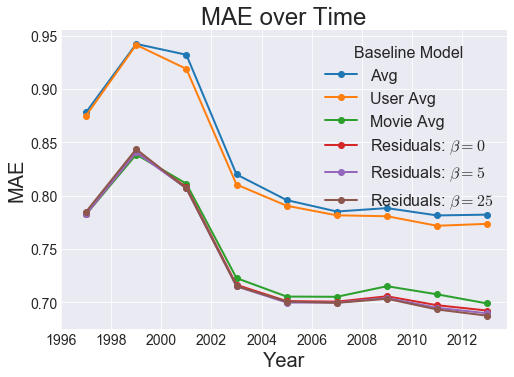

In [73]:
plt.plot(years_1, errs_1, 'o-', label='Avg')
plt.plot(years_2, errs_2, 'o-', label='User Avg')
plt.plot(years_3, errs_3, 'o-', label='Movie Avg')
plt.plot(years_4, errs_4, 'o-', label=r'Residuals: $\beta=0$')
plt.plot(years_5, errs_5, 'o-', label=r'Residuals: $\beta=5$')
plt.plot(years_6, errs_6, 'o-', label=r'Residuals: $\beta=25$')
plt.gca().set_xticks(np.arange(1996, 2013, 2))
plt.xlabel('Year')
plt.ylabel('MAE')
plt.title('MAE over Time')
plt.legend(title='Baseline Model')
plt.show()